<a href="https://colab.research.google.com/github/yerinsally/BDA/blob/main/%EC%A0%95%EC%98%88%EB%A6%B0_0402_%EA%B3%BC%EC%A0%9C.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

titanic 데이터

- 타이타닉 데이터 전처리를 통해서 가장 높은 f1 스코어 만들기
- 교차검증 횟수는 5번 진행하되, 모델링은 자유롭게 하기
1. survived : 생존 여부, 0이면 사망, 1이면 생존
2. pclass : 객실 등급, 1이면 1등급, 2이면 2등급, 3이면 3등급
3. sex : 성별, male이면 남자, female이면 여자
4. age : 나이
5. sibsp : 함께 탑승한 형제 및 배우자 수
6. parch : 함께 탑승한 자녀 및 부모 수
7. fare : 요금
8. embarked : 탑승지 이름 앞글자, C는 Cherbourg, Q는 Queenstown, S는 Southampton
9. class : 객실 등급, First면 1등급, Second면 2등급, Third면 3등급
10. who : 남자, 여자, 아이, man, woman, child
11. adult_male : 성인 남자인지 여부, True면 성인 남자, False면 그외
12. deck : 선실 번호 첫 알파벳, A, B, C, D, E, F, G
13. embark_town : 탑승지 이름, Cherbourg, Queenstown, Southampton
14. alive : 생존여부, no면 사망, yes면 생존
15. alone : 혼자 탑승했는지 여부, True면 혼자 탑승, False면 가족과 함께 탑승

In [14]:
import pandas as pd
import numpy as np
import seaborn as sns
from sklearn.model_selection import train_test_split, KFold, GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.svm import SVC
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
from sklearn.metrics import f1_score, make_scorer

# 데이터 불러오기
titanic_df = sns.load_dataset('titanic')
titanic_df

,survived,pclass,sex,age,sibsp,parch,fare,embarked,class,who,adult_male,deck,embark_town,alive,alone
0,0,3,male,22.0,1,0,7.2500,S,Third,man,True,NaN,Southampton,no,False
1,1,1,female,38.0,1,0,71.2833,C,First,woman,False,C,Cherbourg,yes,False
2,1,3,female,26.0,0,0,7.9250,S,Third,woman,False,NaN,Southampton,yes,True
3,1,1,female,35.0,1,0,53.1000,S,First,woman,False,C,Southampton,yes,False
4,0,3,male,35.0,0,0,8.0500,S,Third,man,True,NaN,Southampton,no,True
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
886,0,2,male,27.0,0,0,13.0000,S,Second,man,True,NaN,Southampton,no,True
887,1,1,female,19.0,0,0,30.0000,S,First,woman,False,B,Southampton,yes,True
888,0,3,female,NaN,1,2,23.4500,S,Third,woman,False,NaN,Southampton,no,False
889,1,1,male,26.0,0,0,30.0000,C,First,man,True,C,Cherbourg,yes,True


In [15]:
titanic_df.describe()

,survived,pclass,age,sibsp,parch,fare
count,891.000000,891.000000,714.000000,891.000000,891.000000,891.000000
mean,0.383838,2.308642,29.699118,0.523008,0.381594,32.204208
std,0.486592,0.836071,14.526497,1.102743,0.806057,49.693429
min,0.000000,1.000000,0.420000,0.000000,0.000000,0.000000
25%,0.000000,2.000000,20.125000,0.000000,0.000000,7.910400
50%,0.000000,3.000000,28.000000,0.000000,0.000000,14.454200
75%,1.000000,3.000000,38.000000,1.000000,0.000000,31.000000
max,1.000000,3.000000,80.000000,8.000000,6.000000,512.329200


In [16]:
# 결측치 확인
titanic_df.isnull().sum()

survived         0
pclass           0
sex              0
age            177
sibsp            0
parch            0
fare             0
embarked         2
class            0
who              0
adult_male       0
deck           688
embark_town      2
alive            0
alone            0
dtype: int64

In [17]:
# 데이터 전처리
def preprocess_data(df):
    
    # 결측치 처리
    df['age'] = df['age'].fillna(df['age'].mean())
    df['fare'] = df['fare'].fillna(df['fare'].mean())
    
    # 범주형 변수 전처리
    df['sex'] = df['sex'].map({'male': 0, 'female': 1}).astype(int)
    df = pd.concat([df, pd.get_dummies(df['embarked'], prefix='embarked')], axis=1)
    df = df.drop('embarked', axis=1)
    df = df.drop('embark_town', axis=1)
    df = df.drop('adult_male', axis=1)
    df = df.drop('alive', axis=1)
    return df

titanic_df = preprocess_data(titanic_df)
titanic_df

,survived,pclass,sex,age,sibsp,parch,fare,class,who,deck,alone,embarked_C,embarked_Q,embarked_S
0,0,3,0,22.000000,1,0,7.2500,Third,man,NaN,False,0,0,1
1,1,1,1,38.000000,1,0,71.2833,First,woman,C,False,1,0,0
2,1,3,1,26.000000,0,0,7.9250,Third,woman,NaN,True,0,0,1
3,1,1,1,35.000000,1,0,53.1000,First,woman,C,False,0,0,1
4,0,3,0,35.000000,0,0,8.0500,Third,man,NaN,True,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
886,0,2,0,27.000000,0,0,13.0000,Second,man,NaN,True,0,0,1
887,1,1,1,19.000000,0,0,30.0000,First,woman,B,True,0,0,1
888,0,3,1,29.699118,1,2,23.4500,Third,woman,NaN,False,0,0,1
889,1,1,0,26.000000,0,0,30.0000,First,man,C,True,1,0,0


In [18]:
titanic_df = pd.get_dummies(titanic_df, columns=['class','deck','who'])
titanic_df

,survived,pclass,sex,age,sibsp,parch,fare,alone,embarked_C,embarked_Q,...,deck_A,deck_B,deck_C,deck_D,deck_E,deck_F,deck_G,who_child,who_man,who_woman
0,0,3,0,22.000000,1,0,7.2500,False,0,0,...,0,0,0,0,0,0,0,0,1,0
1,1,1,1,38.000000,1,0,71.2833,False,1,0,...,0,0,1,0,0,0,0,0,0,1
2,1,3,1,26.000000,0,0,7.9250,True,0,0,...,0,0,0,0,0,0,0,0,0,1
3,1,1,1,35.000000,1,0,53.1000,False,0,0,...,0,0,1,0,0,0,0,0,0,1
4,0,3,0,35.000000,0,0,8.0500,True,0,0,...,0,0,0,0,0,0,0,0,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
886,0,2,0,27.000000,0,0,13.0000,True,0,0,...,0,0,0,0,0,0,0,0,1,0
887,1,1,1,19.000000,0,0,30.0000,True,0,0,...,0,1,0,0,0,0,0,0,0,1
888,0,3,1,29.699118,1,2,23.4500,False,0,0,...,0,0,0,0,0,0,0,0,0,1
889,1,1,0,26.000000,0,0,30.0000,True,1,0,...,0,0,1,0,0,0,0,0,1,0


In [19]:
titanic_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 24 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   survived      891 non-null    int64  
 1   pclass        891 non-null    int64  
 2   sex           891 non-null    int64  
 3   age           891 non-null    float64
 4   sibsp         891 non-null    int64  
 5   parch         891 non-null    int64  
 6   fare          891 non-null    float64
 7   alone         891 non-null    bool   
 8   embarked_C    891 non-null    uint8  
 9   embarked_Q    891 non-null    uint8  
 10  embarked_S    891 non-null    uint8  
 11  class_First   891 non-null    uint8  
 12  class_Second  891 non-null    uint8  
 13  class_Third   891 non-null    uint8  
 14  deck_A        891 non-null    uint8  
 15  deck_B        891 non-null    uint8  
 16  deck_C        891 non-null    uint8  
 17  deck_D        891 non-null    uint8  
 18  deck_E        891 non-null    

In [21]:
titanic_df['alone'] = titanic_df['alone'].astype(int)
titanic_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 24 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   survived      891 non-null    int64  
 1   pclass        891 non-null    int64  
 2   sex           891 non-null    int64  
 3   age           891 non-null    float64
 4   sibsp         891 non-null    int64  
 5   parch         891 non-null    int64  
 6   fare          891 non-null    float64
 7   alone         891 non-null    int64  
 8   embarked_C    891 non-null    uint8  
 9   embarked_Q    891 non-null    uint8  
 10  embarked_S    891 non-null    uint8  
 11  class_First   891 non-null    uint8  
 12  class_Second  891 non-null    uint8  
 13  class_Third   891 non-null    uint8  
 14  deck_A        891 non-null    uint8  
 15  deck_B        891 non-null    uint8  
 16  deck_C        891 non-null    uint8  
 17  deck_D        891 non-null    uint8  
 18  deck_E        891 non-null    

In [22]:
# 학습 데이터, 테스트 데이터 분리
X_train = titanic_df.drop('survived', axis=1)
y_train = titanic_df['survived']
X_test = pd.DataFrame(columns=X_train.columns)

In [23]:
# 모델 학습 및 예측
models = [
    ('LogisticRegression', LogisticRegression()),
    ('KNN', KNeighborsClassifier()),
    ('DecisionTree', DecisionTreeClassifier()),
    ('RandomForest', RandomForestClassifier()),
    ('SVM', SVC()),
    ('GradientBoosting', GradientBoostingClassifier()),
    ('XGBoost', XGBClassifier()),
    ('LightGBM', LGBMClassifier())
]

kfold = KFold(n_splits=5, shuffle=True, random_state=42)
scorer = make_scorer(f1_score)

In [24]:
best_f1_score = 0
best_model_name = None
for name, model in models:
    print('Model: ', name)
    param_grid = {}
    if name == 'LogisticRegression':
        param_grid = {'C': [0.1, 1, 10], 'penalty': ['l1', 'l2']}
    elif name == 'KNN':
        param_grid = {'n_neighbors': [3, 5, 7]}
    elif name == 'DecisionTree':
        param_grid = {'max_depth': [3, 5, 7]}
    elif name == 'RandomForest':
        param_grid = {'n_estimators': [100, 200, 300], 'max_depth': [3, 5, 7]}
        cv_result = GridSearchCV(model, param_grid=param_grid, scoring=scorer, cv=kfold, n_jobs=-1)
        cv_result.fit(X_train, y_train)
        
        y_pred = cv_result.predict(X_train)
        f1 = f1_score(y_train, y_pred)
        print('Best parameters:', cv_result.best_params_)
        print('Best F1 score:', f1)
        
        if f1 > best_f1_score:
            best_f1_score = f1
            best_model_name = name
            best_model = cv_result.best_estimator_

print('\nBest model:', best_model_name)
print('Best F1 score:', best_f1_score)

Model:  LogisticRegression
Model:  KNN
Model:  DecisionTree
Model:  RandomForest
Best parameters: {'max_depth': 7, 'n_estimators': 200}
Best F1 score: 0.8338658146964857
Model:  SVM
Model:  GradientBoosting
Model:  XGBoost
Model:  LightGBM

Best model: RandomForest
Best F1 score: 0.8338658146964857


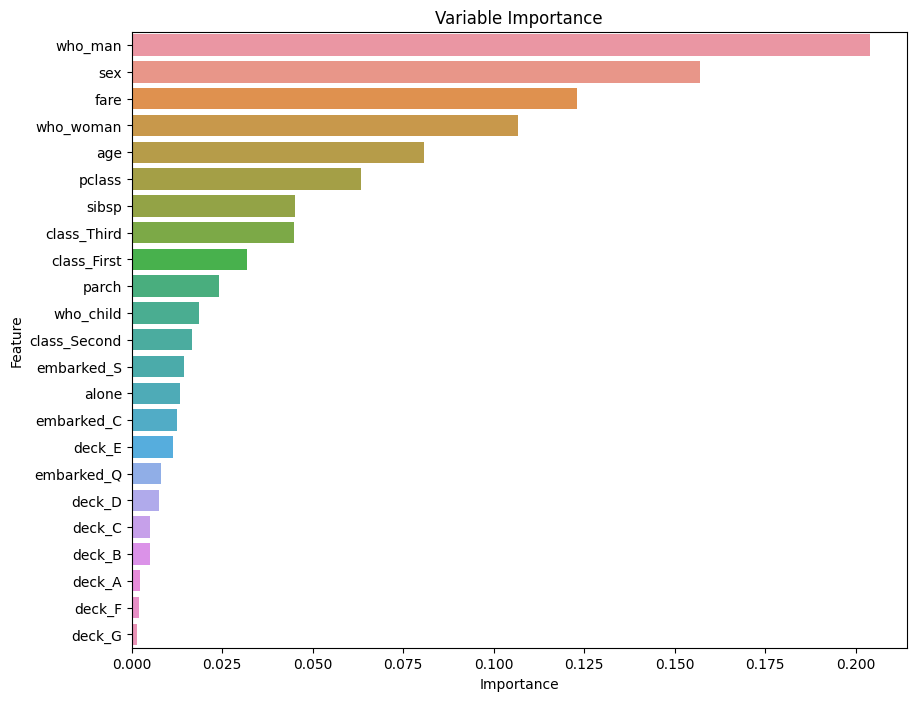

In [26]:
import seaborn as sns
import matplotlib.pyplot as plt

# 모델에서 변수의 중요도 추정
importances = best_model.feature_importances_

# 변수 이름 가져오기
feature_names = X_train.columns

# 중요도를 데이터프레임으로 변환
importance_df = pd.DataFrame({'feature': feature_names, 'importance': importances})

# 중요도 순으로 정렬
importance_df = importance_df.sort_values('importance', ascending=False)

# 막대 그래프로 시각화
plt.figure(figsize=(10, 8))
sns.barplot(x='importance', y='feature', data=importance_df)
plt.title('Variable Importance')
plt.xlabel('Importance')
plt.ylabel('Feature')
plt.show()